
### Imports

In [1]:
%pylab inline
import healpy
from scipy.interpolate import InterpolatedUnivariateSpline

Populating the interactive namespace from numpy and matplotlib


### Options

In [64]:
Nside = 128
lmax = 3*Nside-1

# Binning parameters
dl = 10 # width
Nl = 30 # number
min_l = 2 # minimum

# Number of random iterations
N_it = 20

# Galactic Mask
# Using GAL040 mask with 2-degree apodization for testing
root = '/projects/QUIJOTE/Oliver/planck/'
maskfile = 'HFI_Mask_GalPlane-apo2_2048_R2.00.fits'

### Fiducial Power and Noise Spectrum

In [65]:
from classy import Class
cosmo = Class()

# Define ell arrays
l = np.arange(lmax+1)
l_arr,m_arr = healpy.Alm.getlm(lmax)

# Run CLASS
cosmo.set({'output':'tCl,lCl,mPk','l_max_scalars':lmax+1,'lensing':'yes',
           'omega_b':0.022383,
           'non linear':'no',
           'omega_cdm':0.12011,
           'h':0.6732,
           'm_ncdm':0.06,
           'N_ncdm':1,
           'tau_reio':0.0543,
           'A_s':1e-10*np.exp(3.0448),
           'n_s':0.96605});
cosmo.compute()

# Compute signal C_ell
Cl_dict = cosmo.lensed_cl(lmax);
Cl_th = Cl_dict['tt']*cosmo.T_cmb()**2

# Compute noise C_ell
DeltaT = 60./60.*np.pi/180.*1e-6 # in K-radians
thetaFWHM = 5./60.*np.pi/180. # in radians
Nl_th = DeltaT**2*np.exp(l*(l+1)*thetaFWHM**2/(8.*np.log(2)))

# Interpolate to all ell, m grid
Cl_th_interp = InterpolatedUnivariateSpline(l,Cl_th)
Nl_th_interp = InterpolatedUnivariateSpline(l,Nl_th)
Cl_th_lm = Cl_th_interp(l_arr)
Nl_th_lm = Nl_th_interp(l_arr)

# Zero out ell = 0 and ell = 1
Cl_th_lm[l_arr<2] = 0.
Nl_th_lm[l_arr<2] = 0.

### Load mask

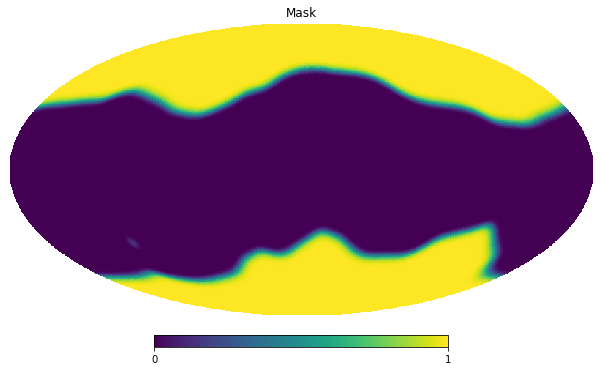

In [66]:
mask = healpy.ud_grade(healpy.read_map(root+maskfile,field=1),Nside)
healpy.mollview(mask,title='Mask')

### Generate Synthetic Data

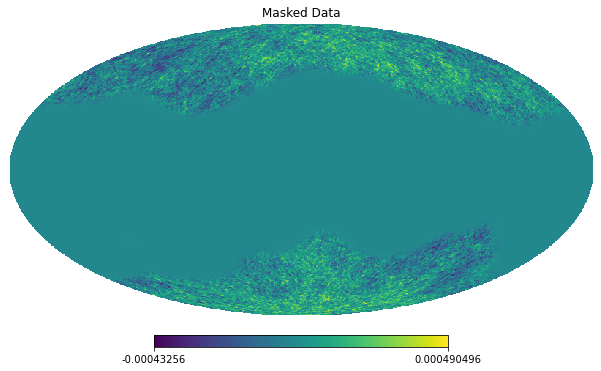

In [67]:
# Generate unmasked data
raw_data = healpy.synfast(Cl_th+Nl_th,Nside)

# Mask the map
data = raw_data*mask

# Plot the data
healpy.mollview(data,title='Masked Data')

# Key Functions

### Creation of $A^{-1}$ weights 

**Ignoring pixel weights**, relation between discrete real- and harmonic-space is
$$a_{\ell m} = \frac{4\pi}{N}\sum_{p}Y_{\ell m}^*(\hat n_p)a(\hat n_p) \quad\leftrightarrow\quad a(\hat n_p) = \sum_{\ell m}Y_{\ell m}(\hat n_p)a_{\ell m}$$
for $N$ pixels.

Thus, the multiplication of two maps is given by
$$\frac{4\pi}{N}\sum_{p}a(\hat n_p)b(\hat n_p) = \sum_{\ell,m\geq 0}a_{\ell m}b^*_{\ell m}\left[1+\delta^{\rm K}_{m>0}\right]$$

We want to create a function $A^{-1}$ that satisfies $\int d\hat n'A^{-1}(\hat n,\hat n')\langle{a(\hat n')a(\hat n'')\rangle} = \delta_{\rm D}(\hat n-\hat n'')$ in continuous space, or, in discrete map-space: $\left(\frac{4\pi}{N}\right)^2\sum_{jk}A^{-1}(\hat n_i,\hat n_j)\langle a(\hat n_j)a(\hat n_k)\rangle \beta(\hat n_k) = \beta(\hat n_i)$ for arbitrary $\beta$. This implies:
\begin{eqnarray}
    A^{-1}(\hat n_i,\hat n_j) =\sum_{\ell m}\frac{1}{C^a_{\ell}}Y_{\ell m}(\hat n_i)Y^*_{\ell m}(\hat n_j)
\end{eqnarray}
A good way to test this is by computing
$$\left(\frac{4\pi}{N}\right)^2\sum_{ij}\alpha(\hat n_i)A^{-1}(\hat n_i,\hat n_j)$$
which should equal $(\ell_{\rm max}+1)^2$.

In [68]:
# Basic HEALPix utilities
def to_lm(input_map):
    """Convert from map-space to harmonic-space"""
    return healpy.map2alm(input_map,pol=False)
def to_map(input_lm):
    """Convert from harmonic-space to map-space"""
    return healpy.alm2map(input_lm,Nside,pol=False)

def safe_divide(x,y):
    """Function to divide maps without zero errors."""
    out = np.zeros_like(x)
    out[y!=0] = x[y!=0]/y[y!=0]
    return out
    
av_sq_mask = np.mean(mask**2)
A_pix = 4.*np.pi/len(mask)
    
def applySinv(input_map):
    """Apply the optimal weighting to a map. 
    
    Here, we assume that the forward covariance is diagonal, in particular < W^2 > (C_l + N_l) and invert this.
    This is not quite the exact solution (as it incorrectly treats W(n) factors), but should be unbiased."""
    
    # Transform to harmonic space
    input_map_lm = to_lm(input_map)
    # Divide by covariance and return to map-space
    Cinv_map = to_map(safe_divide(input_map_lm,Cl_th_lm+Nl_th_lm))
    # Divide by < W^2 > for dimensionality
    output = Cinv_map/av_sq_mask
    
    return output

def generate_alpha(seed):
    """Generate a Gaussian random field with a known (exact) power spectrum.
    
    Here, we assume that the power spectrum is diagonal in ell without a window."""
    # Set seed
    np.random.seed(seed)
    # Generate spectrum
    return healpy.synfast(Cl_th+Nl_th,Nside)

def applyAinv(input_map):
    """Apply the exact inverse weighting A^{-1} to a map."""
    
    # Transform to harmonic space
    input_map_lm = to_lm(input_map)
    # Divide by covariance and return to map-space
    output = to_map(safe_divide(input_map_lm,Cl_th_lm+Nl_th_lm))
    return output

### still missing a $A_{\rm pix}$ factor and $\approx 2 = (1+m>0)$?

### Compute True Power Spectra

(2.0, 383.0)

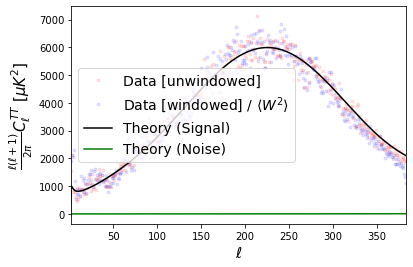

In [69]:
# Compute power spectra
Cl_raw_data = healpy.alm2cl(to_lm(raw_data))
Cl_data = healpy.alm2cl(to_lm(data))/av_sq_mask

# Plot results
pref = l*(l+1)/(2.*np.pi)*1e12
plt.plot(l,pref*Cl_raw_data,label='Data [unwindowed]',ls='',marker='.',alpha=0.1,c='r')
plt.plot(l,pref*Cl_data,label=r'Data [windowed] / $\langle W^2\rangle$',ls='',marker='.',alpha=0.1,c='b')
plt.plot(l,pref*Cl_th,label='Theory (Signal)',c='k')
plt.plot(l,pref*Nl_th,label='Theory (Noise)',c='g')
plt.xlabel(r'$\ell$',fontsize=15)
plt.legend(fontsize=14)
plt.ylabel(r'$\frac{\ell(\ell+1)}{2\pi}C_\ell^{TT}\,\,[\mu K^2]$',fontsize=15)
plt.xlim([2,lmax])

### Compute $h\equiv S^{-1}\tilde{a}$ map and $W h\equiv WS^{-1}\tilde a$

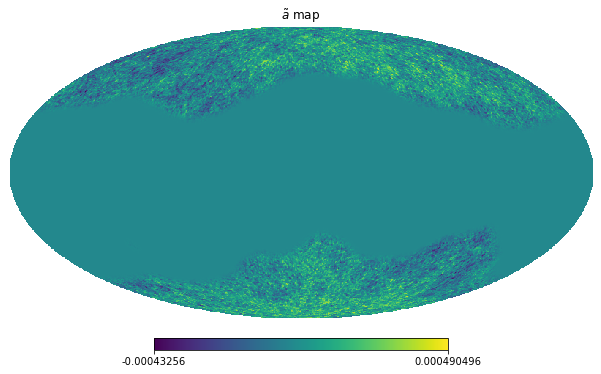

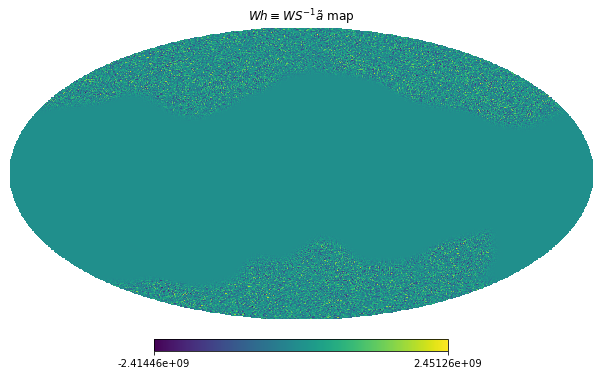

In [70]:
h_data = applySinv(data)
Wh_data = mask*h_data

healpy.mollview(data,title=r'$\tilde{a}$ map')
healpy.mollview(Wh_data,title=r'$Wh\equiv WS^{-1}\tilde{a}$ map')

### Power Spectrum Estimation
The binned power spectrum estimator (including noise) is given by
$$\widehat{C}_b \propto\sum_{\ell m}\Theta_{\ell}(b)[Wh]_{\ell m}[Wh]_{\ell(-m)}$$
with normalization
$$\mathcal{F}_{bb'} = \langle\int d\hat{n}\,d\hat{n}'[WC_{,b}WA^{-1}\alpha](\hat{n})S^{-1}(\hat{n},\hat{n}')[WC_{,b'}WS^{-1}\alpha](\hat{n}')\rangle_{\alpha}$$
or
$$\mathcal{F}_{bb'} = \langle\int d\hat{n}\,d\hat{n}'Q_b[A^{-1}\alpha](\hat{n})S^{-1}(\hat{n},\hat{n}')Q_b[S^{-1}\alpha](\hat{n}')\rangle_\alpha$$
with
$$Q_b[x](\hat{n}) = [WC_{,b}Wx](\hat{n})$$

Now $[C_{,b}\beta](\hat n) = \sum_{\ell m}[\Theta_\ell(b)\beta_{\ell m}^*](\hat n)$

In [ ]:
# Define ell bins
ell_bins = [(l_arr>=min_l+dl*bin1)&(l_arr<min_l+dl*(bin1+1)) for bin1 in range(Nl)]

#### Compute quadratic estimator
Wh_data_lm = to_lm(Wh_data)
Cl_num = [np.real(A_pix*np.sum(Wh_data_lm*np.conj(Wh_data_lm)*ell_bins[i])) for i in range(Nl)]

### Iterate over realizations
fish = np.zeros((Nl,Nl))
all_alpha = []
for seed in range(N_it):

    ## Compute random realization with known power spectrum
    print("Computing alpha %d of %d"%(seed+1,N_it))
    alpha = generate_alpha(seed)
    all_alpha.append(alpha)

    ## Compute weighted fields
    Sinv_alpha = applySinv(alpha)
    Ainv_alpha = applyAinv(alpha)

    ## Compute Q_b fields
    if seed==0: print("Computing Q_b")
    WSinv_alpha_lm = to_lm(mask*Sinv_alpha)
    WAinv_alpha_lm = to_lm(mask*Ainv_alpha)
    Q_b_Sinv_alpha = [to_map(WSinv_alpha_lm*ell_bins[bin1])*mask for bin1 in range(Nl)]
    Q_b_Ainv_alpha = [to_map(WAinv_alpha_lm*ell_bins[bin1])*mask for bin1 in range(Nl)]

    ## Apply S^-1 weighting
    if seed==0: print("Computing S^-1 Q_b")
    Sinv_Q_b_Sinv_alpha = [applySinv(Q_b_Sinv_alpha[bin1]) for bin1 in range(Nl)]

    ## Compute the Fisher matrix
    if seed==0: print("Computing Fisher matrix")
    for bin1 in range(Nl):
        for bin2 in range(Nl):
            fish[bin1,bin2] += np.real(A_pix*np.sum(Q_b_Ainv_alpha[bin1]*(Sinv_Q_b_Sinv_alpha[bin2])))/N_it
        
### Compute full estimator
Cl_est = np.linalg.inv(fish)@Cl_num

Computing alpha 1 of 20
Computing Q_b
Computing S^-1 Q_b
Computing Fisher matrix
Computing alpha 2 of 20
Computing alpha 3 of 20
Computing alpha 4 of 20


### should we add a $\ell_{\rm max}$ for the $S_\ell$ weights to avoid discreteness problems?

#### NB: neglecting pixel window functions!

In [ ]:
# Define arrays
ratio = []
aAia = []

for _ in range(50):
    Nside = 32
    lmax = Nside*3-1
    Npix = 12.*Nside**2
    
    # Area of each pixel
    LL = 10
    A_pix = 4.*np.pi/Npix
    
    l_arr,m_arr = healpy.Alm.getlm(lmax)
    
    # Generate fake spectrum
    Cl_test = np.exp(-l_arr/100.)*(l_arr<LL)+1e-12
    
    # Create a map with this spectrum
    alpha = healpy.synfast(Cl_test,Nside)
    alpha_lm = healpy.map2alm(alpha)*(l_arr<LL)
    
    gamma_sum1 = np.sum(np.real(alpha_lm*alpha_lm.conj())*(1+1.*(m_arr>0)))
    gamma_sum2 = np.sum(alpha**2)*A_pix
    ratio.append(gamma_sum1/gamma_sum2)
    
    Ainv_alpha_lm = alpha_lm/Cl_test/(2*l_arr+1)*np.pi*4
    Ainv_alpha = healpy.alm2map(Ainv_alpha_lm,Nside)
    aAia.append(Ainv_alpha*alpha)

print("Ratio: ",np.mean(ratio))
print("<a A^-1 a> : %.2e %.2e"%(np.mean(aAia),np.std(aAia)/np.sqrt(len(np.asarray(aAia).ravel()))))

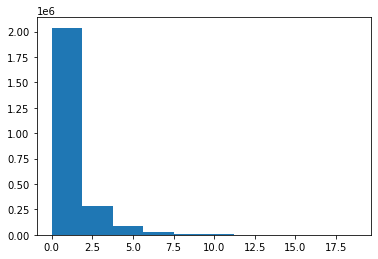

In [609]:
plt.hist(np.asarray(aAia).reshape(-1,1));

Relation between real- and harmonic-space is
$$a_{\ell m} = \frac{4\pi}{N}\sum_{p}Y_{\ell m}^*(\hat n_p)a(\hat n_p) \quad\leftrightarrow\quad a(\hat n_p) = \sum_{\ell m}Y_{\ell m}(\hat n_p)a_{\ell m}$$
for $N$ pixels.

Thus, the multiplication of two maps is given by
$$\frac{4\pi}{N}\sum_{p}a(\hat n_p)b(\hat n_p) = \sum_{\ell,m\geq 0}a_{\ell m}b^*_{\ell m}\left[1+\delta^{\rm K}_{m>0}\right]$$

We want to create a function $A^{-1}$ that satisfies $\langle{a(\hat n)a(\hat n')A^{-1}(\hat n,\hat n')\rangle}$

The real-space covariance is then given by
\begin{eqnarray}
    A(\hat n_p,\hat n_q) &\equiv& \langle a(\hat n_p)a(\hat n_q)\rangle\\\nonumber
    &=& \sum_{\ell m}C^a_{\ell}Y_{\ell m}(\hat n_p)Y^*_{\ell m}(\hat n_q)
\end{eqnarray}
so
\begin{eqnarray}
    \left(\frac{4\pi}{N}\right)^2\sum_{pq}a(\hat n_p)A(\hat n_p,\hat n_q)b(\hat n_q) &=& \sum_{\ell m}C^a_{\ell}a_{\ell m}^*b_{\ell m}
\end{eqnarray}

Thus,
\begin{eqnarray}
    \langle\sum_{pq}a(\hat n_p)A^{-1}(\hat n_p,\hat n_q)a(\hat n_q)\rangle &=& \frac{N^2}{(4\pi)^2}\sum_{\ell }(2\ell+1)
\end{eqnarray}


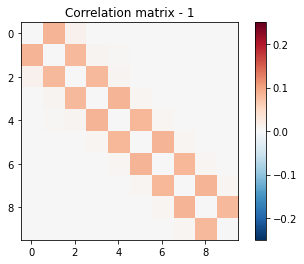

In [54]:
corr_fish = fish/np.sqrt(np.outer(np.diag(fish),np.diag(fish)))
v = 0.25
plt.imshow(corr_fish-np.eye(len(corr_fish)),cmap=cm.RdBu_r,vmax=v,vmin=-v)
plt.title("Correlation matrix - 1")
plt.colorbar();

#### need to fix normalization!!

(0.0, 100.0)

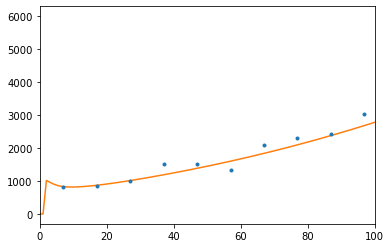

In [62]:
l_av = np.asarray([min_l+dl/2+dl*bin1 for bin1 in range(Nl)])
pref_av = l_av*(l_av+1.)/(2.*np.pi)*1e12


fish_err = np.sqrt(np.diag(np.linalg.inv(fish)))
plt.errorbar(l_av,pref_av*Cl_est,yerr=0*pref_av*fish_err,marker='.',ls='')
plt.plot(l,pref*Cl_th)
plt.xlim([0,100])

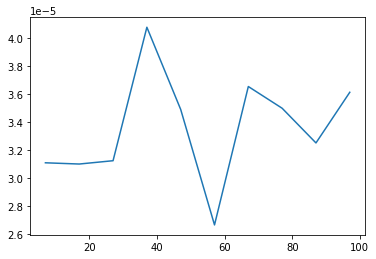

In [63]:
plt.plot(l_av,Cl_est/Cl_th_interp(l_av))

### worth trying with weird mask with more structure?

### first aim: check that the power spectrum estimator is unbiased, and that Fisher matrix gives correct variance